![MLU Logo](../data/MLU_Logo.png)

# <a name="0">Machine Learning Accelerator - Natural Language Processing - Lecture 3</a>

## Neural Networks with Gluon

In this notebook, we will build, train and validate a Neural Network using Gluon/MXNet.
1. <a href="#1">Implementing a neural network with Gluon</a>
2. <a href="#2">Loss Functions</a>
3. <a href="#3">Training</a>
4. <a href="#4">Example - Binary Classification</a>
5. <a href="#5">Natural Language Processing Context</a>

In [ ]:
! pip install -q -r ../requirements.txt

## 1. <a name="1">Implementing a neural network with Gluon</a>
(<a href="#0">Go to top</a>)

Let's implement a simple neural network with two hidden layers of size 64 and 128 using the sequential mode (Adding things in sequence). We will have 3 inputs, 2 hidden layers and 1 output layer. Some drop-outs attached to the hidden layers.

In [1]:
from mxnet.gluon import nn

net = nn.Sequential()

net.add(nn.Dense(64,                    # Dense layer-1 with 64 units
                 in_units=3,            # Input size of 3 is expected
                 activation='tanh'),    # Tanh activation is applied
        nn.Dropout(.4),                 # Apply random 40% drop-out to layer_1
        
        nn.Dense(64,                    # Dense layer-2 with 64 units  
                 activation='tanh'      # Tanh activation is applied
                ),
        nn.Dropout(.3),                 # Apply random 30% drop-out to layer_2
        
        nn.Dense(1))                    # Output layer with single unit

print(net)

Sequential(
  (0): Dense(3 -> 64, Activation(tanh))
  (1): Dropout(p = 0.4, axes=())
  (2): Dense(None -> 64, Activation(tanh))
  (3): Dropout(p = 0.3, axes=())
  (4): Dense(None -> 1, linear)
)


We can initialize the weights of the network with 'initialize()' function. We prefer to use the following:

In [2]:
from mxnet import init

net.initialize(init=init.Xavier())

Let's look at our layers and dropouts on them. We can easily access them wth net[layer_index]

In [3]:
print(net[0])
print(net[1])
print(net[2])
print(net[3])
print(net[4])

Dense(3 -> 64, Activation(tanh))
Dropout(p = 0.4, axes=())
Dense(None -> 64, Activation(tanh))
Dropout(p = 0.3, axes=())
Dense(None -> 1, linear)


## 2. <a name="2">Loss Functions</a>
(<a href="#0">Go to top</a>)

We will go over some popular loss functions here. We can select loss functions according to our problem. Full list of supported loss functions are available [here](https://mxnet.incubator.apache.org/api/python/docs/api/gluon/loss/index.html)


__Binary Cross-entropy Loss:__ A common loss function for binary classification. It is given by: 
$$
\mathrm{BinaryCrossEntropyLoss} = -\sum_{examples}{(y\log(p) + (1 - y)\log(1 - p))}
$$
where p is the prediction (between 0 and 1, ie. 0.831) and y is the true class (either 1 or 0). 

In gluon, we can use binary cross entropy with `SigmoidBinaryCrossEntropyLoss`. It also applies sigmoid function on the predictions. Therefore, p is always between 0 and 1.


```python
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss
loss = SigmoidBinaryCrossEntropyLoss()
```
__Categorical Cross-entropy Loss:__ It is used for multi-class classification. We apply the softmax function on prediction probabilities and then extend the equation of binary cross-entropy. After the softmax function, summation of the predictions are equal to 1. Equation is below. y becomes 1 for true class and 0 for other classes.
$$
\mathrm{CategoricalCrossEntropyLoss} = -\sum_{examples}\sum_{classes}{y_j\log(p_j)}
$$
In gluon, `SoftmaxCrossEntropyLoss` implements the categorical cross-entropy loss with softmax function


```python
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
loss = SoftmaxCrossEntropyLoss()
```
__L2 Loss:__ This is a loss function for regression problems. It measures the squared difference between target values (y) and predictions (p). Here, square makes sure the offsets with different signs don't cancel out each other.
$$
\mathrm{L2 loss} = \frac{1}{2} \sum_{examples}(y - p)^2
$$
In gluon, we can use it with `L2Loss`:
```python
from mxnet.gluon.loss import L2Loss
loss = L2Loss()
```
__L1 Loss:__ This is similar to L2 loss. It measures the abolsute difference between target values (y) and predictions (p).
$$
\mathrm{L1 loss} = \frac{1}{2} \sum_{examples}|y - p|
$$
In gluon, we can use it with `L1Loss`:
```python
from mxnet.gluon.loss import L1Loss
loss = L1Loss()
```

## 3. <a name="3">Training</a>
(<a href="#0">Go to top</a>)

`mxnet.gluon.Trainer()` module provides necessary training algorithms for neural networks. We can use the following for training a network using Stochastic Gradient Descent method and learning rate of 0.001.

```python
from mxnet import gluon

trainer = gluon.Trainer(net.collect_params(),
                        'sgd', 
                        {'learning_rate': 0.001}
                       )
```

## 4. <a name="4">Example - Binary Classification</a>
(<a href="#0">Go to top</a>)

Let's train a neural network on a random dataset. We have two classes and will learn to classify them.

In [4]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=750, shuffle=True, random_state=42, noise=0.05, factor=0.3)

Let's plot the dataset

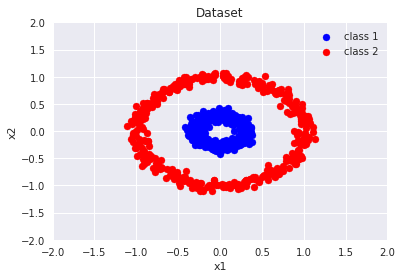

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dataset(X, y, title):
    
    # Activate Seaborn visualization
    sns.set()
    
    # Plot both classes: Class1->Blue, Class2->Red
    plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', label="class 1")
    plt.scatter(X[y==0, 0], X[y==0, 1], c='red', label="class 2")
    plt.legend(loc='upper right')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.title(title)
    plt.show()
    
plot_dataset(X, y, title="Dataset")

Importing the necessary libraries

In [6]:
import time
import mxnet as mx
from mxnet import gluon, autograd
import mxnet.ndarray as nd
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss

We are creating the network below. We will have two hidden layers. Since the data seems easily seperable, we can have a small network (2 hidden layers) with 10 units at each layer.

In [7]:
from mxnet import init
from mxnet.gluon import nn

net = nn.Sequential()
net.add(nn.Dense(10, in_units=2, activation='relu'),
        nn.Dense(10, activation='relu'),
        nn.Dense(1, activation='sigmoid'))
net.initialize(init=init.Xavier())

Let's define the training parameters

In [8]:
batch_size = 4           # How many samples to use for each weight update 
epochs = 50              # Total number of iterations
learning_rate = 0.01     # Learning rate
context = mx.cpu()       # Using CPU resource

# Define the loss. As we used sigmoid in the last layer, use from_sigmoid=True
binary_cross_loss = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)

# Define the trainer, SGD with learning rate
trainer = gluon.Trainer(net.collect_params(),
                        'sgd',
                        {'learning_rate': learning_rate}
                       )

In [9]:
# Splitting the dataset into two parts: 80%-20% split
X_train, X_val = X[0:int(len(X)*0.8), :], X[int(len(X)*0.8):, :]
y_train, y_val = y[:int(len(X)*0.8)], y[int(len(X)*0.8):]

# Convert to ND arrays for gluon
X_train = nd.array(X_train)
X_val = nd.array(X_val)
y_train = nd.array(y_train)
y_val = nd.array(y_val)

# Using Gluon Data loaders to load the data in batches
train_dataset = gluon.data.ArrayDataset(X_train, y_train)
train_loader = gluon.data.DataLoader(train_dataset, batch_size=batch_size)

Let's start the training process. We will have training and validation sets and print our losses at each step.

In [10]:
import time

train_losses = []
val_losses = []
for epoch in range(epochs):
    start = time.time()
    training_loss = 0
    # Training loop, train the network
    for idx, (data, target) in enumerate(train_loader):

        data = data.as_in_context(context)
        target = target.as_in_context(context)
        
        with autograd.record():
            output = net(data)
            L = binary_cross_loss(output, target)
            training_loss += nd.sum(L).asscalar()
            L.backward()
        trainer.step(data.shape[0])
    
    # Get validation predictions
    val_predictions = net(X_val.as_in_context(context))
    # Calculate validation loss
    val_loss = nd.sum(binary_cross_loss(val_predictions, y_val)).asscalar()
    
    # Let's take the average losses
    training_loss = training_loss / len(y_train)
    val_loss = val_loss / len(y_val)
    
    train_losses.append(training_loss)
    val_losses.append(val_loss)
    
    end = time.time()
    print("Epoch %s. Train_loss %f Validation_loss %f Seconds %f" % \
          (epoch, training_loss, val_loss, end-start))

Epoch 0. Train_loss 0.717287 Validation_loss 0.707328 Seconds 0.614809
Epoch 1. Train_loss 0.698457 Validation_loss 0.694622 Seconds 0.490713
Epoch 2. Train_loss 0.683981 Validation_loss 0.681235 Seconds 0.483390
Epoch 3. Train_loss 0.670197 Validation_loss 0.667785 Seconds 0.480852
Epoch 4. Train_loss 0.653411 Validation_loss 0.648352 Seconds 0.475950
Epoch 5. Train_loss 0.632768 Validation_loss 0.627517 Seconds 0.475139
Epoch 6. Train_loss 0.611411 Validation_loss 0.606206 Seconds 0.476629
Epoch 7. Train_loss 0.588618 Validation_loss 0.582911 Seconds 0.478786
Epoch 8. Train_loss 0.564000 Validation_loss 0.557464 Seconds 0.478083
Epoch 9. Train_loss 0.536602 Validation_loss 0.528374 Seconds 0.479107
Epoch 10. Train_loss 0.505457 Validation_loss 0.494894 Seconds 0.477709
Epoch 11. Train_loss 0.470475 Validation_loss 0.457515 Seconds 0.475215
Epoch 12. Train_loss 0.432076 Validation_loss 0.416653 Seconds 0.472537
Epoch 13. Train_loss 0.391388 Validation_loss 0.374049 Seconds 0.475051
Ep

Let's see the training and validation loss plots below. Losses go down as the training process continues as expected.

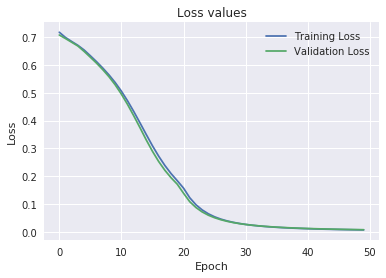

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 5. <a name="5">Natural Language Processing Context</a>
(<a href="#0">Go to top</a>)

If we want to use the same type of architecture for text classification, we need to apply some feature extraction methods first. For example: We can get TF-IDF vectors of text fields. After that, we can use neural networks on those features. 

We will also look at __more advanced neural network architrectures__ such as __Recurrent Neural Networks (RNNs)__, __Long Short-Term Memory networks (LSTMs)__ and __Transformers__. 